In [565]:
import pandas as pd
import numpy as np
import re

### This notebook has analysis/correlation work on player performance and different search sites. Many of the tests ran here were ran again in seperate notebooks for ease of use. This notebook was more of a testing place for me to try new methods.

In [113]:
data = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2021-04-01' AND DATE '2021-06-30' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3
), hitters AS (
      SELECT player_id
           , player_name
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2
), pitcher_war AS (
      SELECT player_id
           , player_name
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
)
SELECT 
     player_id
     , player_name
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 1366/1366 [00:00<00:00, 5311.91rows/s]


In [114]:
data

,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
0,518774,Matthew Harvey,P,0.000000,-1.9212,-1.921200,0.000000
1,622075,Yency Almonte,P,0.000000,-1.5110,-1.511000,0.000733
2,641745,Brad Keller,P,0.000000,-1.4238,-1.423800,0.001465
3,677976,Randy Dobnak,P,0.000000,-1.3350,-1.335000,0.002198
4,462101,Elvis Andrus,H,-1.295155,0.0000,-1.295155,0.002930
...,...,...,...,...,...,...,...
1361,554430,Zachary Wheeler,H,0.000000,3.4726,3.472600,0.997070
1362,665489,Vladimir Guerrero,H,3.512474,0.0000,3.512474,0.997802
1363,605540,Brandon Woodruff,H,0.000000,3.6768,3.676800,0.998535
1364,594798,Jacob deGrom,H,0.000000,3.9240,3.924000,0.999267


In [4]:
#similar web

In [7]:
metrics = pd.read_csv('data/player_search_metrics.csv')

In [8]:
metrics.head()

,Keywords,Traffic Share,Volume,CPC,Leader,Clicked,Non-Clicked,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03
0,shohei ohtani,16.37%,"1,000,080",$0.86,mlb.com,44.35%,55.65%,"919,061","1,396,720","1,424,405","3,522,067","1,526,172","1,112,328","579,079","446,508","237,176","328,635","252,952","255,862"
1,freddie freeman,4.97%,"506,309",$2.88,baseball-reference.com,43.16%,56.84%,"234,470","148,131","99,382","214,942","196,105","120,110","508,577","930,444","414,413","207,846","244,103","2,757,190"
2,mike trout,4.52%,"428,286",$0.69,baseball-reference.com,43.35%,56.65%,"760,428","848,119","484,105","874,295","676,181","326,054","246,467","182,973","130,324","164,884","182,300","263,313"
3,max scherzer,4.36%,"400,615",$0.82,baseball-reference.com,42.85%,57.15%,"180,133","195,950","345,213","948,819","456,773","552,683","668,647","738,866","207,011","98,085","114,821","300,379"
4,jacob degrom,3.76%,"281,489",$0.71,baseball-reference.com,44.51%,55.49%,"557,062","409,848","1,096,135","518,797","239,974","149,306","76,253","74,811","51,272","32,583","43,850","127,979"


In [9]:
test = data

In [10]:
test['Keywords'] = data['player_name'].str.lower()

In [11]:
test_merge = test.merge(metrics, how = 'inner')

In [12]:
test_merge = test_merge.drop(columns=['CPC', 'Traffic Share', 'Keywords','Leader', 'Clicked', 'Non-Clicked'])

In [13]:
test_merge

,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,Volume,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03
0,641355,Cody Bellinger,H,-0.549546,0.0000,-0.549546,0.048423,"197,998","300,243","291,211","194,981","279,432","264,059","277,425","406,071","73,177","78,717","40,767","35,709","134,192"
1,608337,Lucas Giolito,P,0.000000,-0.2648,-0.264800,0.114453,"30,317","81,258","44,874","39,888","44,206","44,564","15,720","34,987","16,126","7,142","7,649","4,928","22,473"
2,605483,Blake Snell,P,0.000000,-0.2454,-0.245400,0.120323,"67,037","135,324","137,901","130,326","102,489","83,628","100,556","34,946","11,539","8,238","14,359","6,406","38,733"
3,596019,Francisco Lindor,H,-0.224570,0.0000,-0.224570,0.129127,"166,338","403,875","372,957","260,352","238,542","209,777","195,405","80,434","78,543","40,151","18,229","25,224","72,576"
4,608369,Corey Seager,H,-0.093025,0.0000,-0.093025,0.172414,"190,024","158,297","146,180","129,958","199,282","125,561","121,215","352,922","572,662","198,327","63,178","50,369","162,338"
5,650391,Eloy Jimenez,H,-0.050899,0.0000,-0.050899,0.189288,"38,919","75,185","50,537","53,975","120,350","89,216","23,298","14,863","6,312","5,496","6,960","6,881","13,962"
6,669022,MacKenzie Gore,None,0.000000,0.0000,0.000000,0.216434,"21,124","36,446","34,506","34,074","42,666","37,101","13,813","6,996","4,854","3,131","2,420","3,965","33,519"
7,665487,Fernando Tatis,None,0.000000,0.0000,0.000000,0.216434,"36,556","134,934","43,872","53,569","60,070","34,664","30,843","20,924","9,788","8,646","5,955","6,846","28,564"
8,666808,Camilo Doval,None,0.000000,0.0000,0.000000,0.216434,"14,210","8,128","7,628",400,"3,701","3,094","33,363","82,869","4,489","6,325","5,874","2,102","12,558"
9,669358,Shane Baz,None,0.000000,0.0000,0.000000,0.216434,"22,337","4,181","7,640","22,595","32,580","38,376","48,397","50,549","5,163","10,524","5,099","6,146","36,805"


In [14]:
#test_merge['Volume'] = test_merge['Volume'].str.replace(',', '').astype(float)

In [15]:
test_merge['2021-04'] = test_merge['2021-04'].str.replace(',', '').astype(float)

In [16]:
test_merge['2021-05'] = test_merge['2021-05'].str.replace(',', '').astype(float)

In [17]:
test_merge['2021-06'] = test_merge['2021-06'].str.replace(',', '').astype(float)

In [18]:
test_merge['player_id'] = test_merge['player_id'].astype(int)

In [19]:
test_merge['dates_sum'] = test_merge['2021-04'] + test_merge['2021-05'] + test_merge['2021-06']

In [20]:
test_merge = test_merge.drop(columns=['2021-04', '2021-05', '2021-06', 'Volume'])

In [21]:
test_merge.corr(method = 'pearson')

,player_id,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dates_sum
player_id,1.000000,-0.239458,-0.113888,-0.256408,-0.397030,-0.252783
hitting_quickwar,-0.239458,1.000000,-0.079794,0.644995,0.623210,0.248990
pitching_quickwar,-0.113888,-0.079794,1.000000,0.710283,0.460565,0.347463
total_quickwar,-0.256408,0.644995,0.710283,1.000000,0.793174,0.442205
performance_rank,-0.397030,0.623210,0.460565,0.793174,1.000000,0.201926
dates_sum,-0.252783,0.248990,0.347463,0.442205,0.201926,1.000000


In [22]:
test_merge

,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,dates_sum
0,641355,Cody Bellinger,H,-0.549546,0.0000,-0.549546,0.048423,"279,432","264,059","277,425","406,071","73,177","78,717","40,767","35,709","134,192",786435.0
1,608337,Lucas Giolito,P,0.000000,-0.2648,-0.264800,0.114453,"44,206","44,564","15,720","34,987","16,126","7,142","7,649","4,928","22,473",166020.0
2,605483,Blake Snell,P,0.000000,-0.2454,-0.245400,0.120323,"102,489","83,628","100,556","34,946","11,539","8,238","14,359","6,406","38,733",403551.0
3,596019,Francisco Lindor,H,-0.224570,0.0000,-0.224570,0.129127,"238,542","209,777","195,405","80,434","78,543","40,151","18,229","25,224","72,576",1037184.0
4,608369,Corey Seager,H,-0.093025,0.0000,-0.093025,0.172414,"199,282","125,561","121,215","352,922","572,662","198,327","63,178","50,369","162,338",434435.0
5,650391,Eloy Jimenez,H,-0.050899,0.0000,-0.050899,0.189288,"120,350","89,216","23,298","14,863","6,312","5,496","6,960","6,881","13,962",179697.0
6,669022,MacKenzie Gore,None,0.000000,0.0000,0.000000,0.216434,"42,666","37,101","13,813","6,996","4,854","3,131","2,420","3,965","33,519",105026.0
7,665487,Fernando Tatis,None,0.000000,0.0000,0.000000,0.216434,"60,070","34,664","30,843","20,924","9,788","8,646","5,955","6,846","28,564",232375.0
8,666808,Camilo Doval,None,0.000000,0.0000,0.000000,0.216434,"3,701","3,094","33,363","82,869","4,489","6,325","5,874","2,102","12,558",16156.0
9,669358,Shane Baz,None,0.000000,0.0000,0.000000,0.216434,"32,580","38,376","48,397","50,549","5,163","10,524","5,099","6,146","36,805",34416.0


In [23]:
#savant

In [115]:
savant_page_loads = pd.read_gbq('''

WITH initial_query AS (

SELECT DISTINCT page_url, visit
FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads` 

    WHERE page_url LIKE 'https://urldefense.com/v3/__https://baseballsavant.mlb.com/savant-player*'*5Cn__;JSU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWPR02sRA$      AND date_time_date >= '2021-04-01' AND date_time_date < '2021-07-01'
)

SELECT page_url, count(*) as visits
FROM initial_query
GROUP BY page_url
ORDER BY 2 desc


''')

Downloading: 100%|██████████| 31502/31502 [00:00<00:00, 36543.86rows/s]


In [66]:
savant_names = []
for i in savant_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        savant_names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        savant_names.append(m.group(0))

In [67]:
savant_full = savant_page_loads


In [68]:
savant_full['construct'] = savant_names

In [73]:
savant_full['name'] = savant_full['construct'].apply(lambda x: "-".join(x.split("-")[:2]))
savant_full['name'] = savant_full['name'].apply(lambda x: x.replace('-',' '))
savant_full['player_id'] = savant_full['construct'].apply(lambda x: x.split('-')[-1:][0])
savant_full = savant_full.head(2300)
savant_full['player_id'] = pd.to_numeric(savant_full["player_id"])
savant_full['player_id'] = (savant_full['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkV

In [74]:
savant_full

,page_url,visits,construct,name,player_id
0,https://urldefense.com/v3/__https://baseballsavant.mlb.com/savant-player/s__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqW3mSKPCQ$ ...,67052,shohei-ohtani-660271,shohei ohtani,660271
1,https://urldefense.com/v3/__https://baseballsavant.mlb.com/savant-player/a__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUTs7dp5Q$ ...,60605,aaron-judge-592450,aaron judge,592450
2,https://urldefense.com/v3/__https://baseballsavant.mlb.com/savant-player/j__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVJSM2nqg$ ...,44033,julio-rodriguez-677594,julio rodriguez,677594
3,https://urldefense.com/v3/__https://baseballsavant.mlb.com/savant-player/m__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWlW1CkoA$ ...,43614,mike-trout-545361,mike trout,545361
4,https://urldefense.com/v3/__https://baseballsavant.mlb.com/savant-player/t__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqX8qx4l9g$ ...,31844,taylor-ward-621493,taylor ward,621493
...,...,...,...,...,...
2295,https://urldefense.com/v3/__https://baseballsavant.mlb.com/savant-player/j__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVJSM2nqg$ ...,120,jake-hager-606993,jake hager,606993
2296,https://urldefense.com/v3/__https://baseballsavant.mlb.com/savant-player/d__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWAFd3eFw$ ...,120,dan-winkler-595465,dan winkler,595465
2297,https://urldefense.com/v3/__https://baseballsavant.mlb.com/savant-player/t__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqX8qx4l9g$ ...,120,travis-jankowski-608671,travis jankowski,608671
2298,https://urldefense.com/v3/__https://baseballsavant.mlb.com/savant-player/y__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUeUxVH7w$ ...,120,yu-chang-644374,yu chang,644374


In [78]:
savant_merge = savant_full.merge(test_merge, how ='right')

In [77]:
savant_full.corr(method = 'pearson')

,visits,player_id
visits,1.000000,0.020897
player_id,0.020897,1.000000


In [32]:
#film room

In [33]:
film_room_searches = pd.read_gbq('''

WITH initial_query AS (

SELECT DISTINCT page_url, visit
FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads` 

    WHERE page_url LIKE 'https://urldefense.com/v3/__https://www.mlb.com/video/search?q=*'*5Cn__;JSU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWhR2HZSw$      AND date_time_date >= '2022-04-01' AND date_time_date < '2022-07-01'
)

SELECT page_url, count(*) as visits
FROM initial_query
GROUP BY page_url
ORDER BY 2 desc
''')

Downloading: 100%|██████████| 55702/55702 [00:01<00:00, 39441.92rows/s]


In [34]:
queries = []
for i in film_room_searches['page_url']:
    m = re.search('(?<=q=)([^&]*)(?=&)?', i)
    if len(m.group(0)) < 30:
        queries.append(m.group(0))
    else: 
        queries.append("")
film_room_searches['construct'] = queries
for i in film_room_searches['construct']:
    if '+' in i:
        film_room_searches['construct'].apply(lambda x: x.replace('+',' '))
    else:
        continue


In [35]:
film_room_searches['construct'] = film_room_searches['construct'].apply(lambda x: x.replace('+',' '))
film_room_searches['first_last'] = film_room_searches['construct']

In [36]:
film_room_searches

,page_url,visits,construct,first_last
0,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=BatterId**A3__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV76DcdVw$ ...,3615,,
1,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Daulton*Var__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVA1-KxtQ$ ...,2919,Daulton Varsho,Daulton Varsho
2,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=BatterId**A3__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV76DcdVw$ ...,2096,,
3,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXW0gIcmQ$,2011,,
4,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=ContentTags__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVFHLIqRw$ ...,2001,,
...,...,...,...,...
55697,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=PitcherId**A__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWmHP0QaQ$ ...,1,,
55698,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=BatterId**A3__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV76DcdVw$ ...,1,,
55699,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=BatterId**A3__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV76DcdVw$ ...,1,,
55700,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=BatterId**A3__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV76DcdVw$ ...,1,,


In [37]:
film_room_searches['player_name'] = film_room_searches['first_last']

In [38]:
film_merge = film_room_searches.merge(test_merge, how ='right')

In [39]:
film_merge

,page_url,visits,construct,first_last,player_name,player_id,position,hitting_quickwar,pitching_quickwar,total_quickwar,...,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,dates_sum
0,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Adley*Rutsc__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVpdX6k5A$ ...,722.0,Adley Rutschman,Adley Rutschman,Adley Rutschman,668939,None,0.000000,0.0000,0.000000,...,"65,768","73,243","31,259","22,381","15,252","17,662","14,993","32,788","75,301",175098.0
1,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Adley*Rutsc__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVpdX6k5A$ ...,30.0,Adley Rutschman,Adley Rutschman,Adley Rutschman,668939,None,0.000000,0.0000,0.000000,...,"65,768","73,243","31,259","22,381","15,252","17,662","14,993","32,788","75,301",175098.0
2,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Adley*Rutsc__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVpdX6k5A$ ...,1.0,Adley Rutschman,Adley Rutschman,Adley Rutschman,668939,None,0.000000,0.0000,0.000000,...,"65,768","73,243","31,259","22,381","15,252","17,662","14,993","32,788","75,301",175098.0
3,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Shohei*Ohta__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV_eZ3moQ$ ...,626.0,Shohei Ohtani,Shohei Ohtani,Shohei Ohtani,660271,H,1.070594,2.2816,3.352194,...,"3,522,067","1,526,172","1,112,328","579,079","446,508","237,176","328,635","252,952","255,862",3740186.0
4,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Bo*Bichette__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXveS8nyg$ ...,624.0,Bo Bichette,Bo Bichette,Bo Bichette,666182,H,0.238766,0.0000,0.238766,...,"160,300","107,080","181,040","55,487","37,754","31,865","21,482","27,332","78,546",401451.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,NaN,NaN,NaN,NaN,Luis Gil,661563,None,0.000000,0.0000,0.000000,...,"5,141","122,424","33,818","16,681","8,835","5,254","3,707","3,991","10,267",10883.0
100,NaN,NaN,NaN,NaN,Jack Flaherty,656427,P,0.000000,0.0640,0.064000,...,"37,675","30,894","39,759","18,037","17,290","7,891","6,251","15,084","69,174",165562.0
101,NaN,NaN,NaN,NaN,Marcus Stroman,573186,P,0.000000,0.4720,0.472000,...,"125,273","88,437","61,711","71,392","244,805","133,815","23,858","59,326","83,850",336021.0
102,NaN,NaN,NaN,NaN,Ronald Acuna,660670,H,0.652790,0.0000,0.652790,...,"172,367","42,641","35,665","115,840","77,351","18,628","22,869","15,773","74,752",342581.0


In [40]:
film_merge.corr(method = 'pearson')

,visits,player_id,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dates_sum
visits,1.000000,0.193578,0.099044,0.128923,0.160163,0.133420,0.289371
player_id,0.193578,1.000000,-0.064056,-0.045443,-0.076726,-0.088114,-0.272112
hitting_quickwar,0.099044,-0.064056,1.000000,0.013099,0.701528,0.676111,0.206645
pitching_quickwar,0.128923,-0.045443,0.013099,1.000000,0.721770,0.482305,0.328754
total_quickwar,0.160163,-0.076726,0.701528,0.721770,1.000000,0.811740,0.377342
performance_rank,0.133420,-0.088114,0.676111,0.482305,0.811740,1.000000,0.120238
dates_sum,0.289371,-0.272112,0.206645,0.328754,0.377342,0.120238,1.000000


In [41]:
#mlb search (player page loads)

In [42]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2022-04-01' AND date_time_date < '2022-07-01'
    )




        SELECT page_url, count(*) as visits
        FROM initial_query
        GROUP BY page_url
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 609138/609138 [00:20<00:00, 29923.15rows/s]


In [43]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [44]:
full_player_page = player_page_loads

In [45]:
full_player_page['construct'] = names
full_player_page['name'] = full_player_page['construct'].apply(lambda x: "-".join(x.split("-")[:2]))
full_player_page['name'] = full_player_page['name'].apply(lambda x: x.replace('-',' '))
full_player_page['player_id'] = full_player_page['construct'].apply(lambda x: x.split('-')[-1:][0])
full_player_page = full_player_page.head(3000)
full_player_page['player_id'] = pd.to_numeric(full_player_page["player_id"])
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    import sys


In [46]:
full_player_page

,page_url,visits,construct,name,player_id
0,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-660271__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqU13e5xGw$,670824,shohei-ohtani-660271,shohei ohtani,660271
1,https://urldefense.com/v3/__https://www.mlb.com/player/mike-trout-545361__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWiSkIh0A$,368819,mike-trout-545361,mike trout,545361
2,https://urldefense.com/v3/__https://www.mlb.com/player/aaron-judge-592450__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVlXeGh_Q$,358762,aaron-judge-592450,aaron judge,592450
3,https://urldefense.com/v3/__https://www.mlb.com/player/freddie-freeman-518692__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXTBwDL6g$,198801,freddie-freeman-518692,freddie freeman,518692
4,https://urldefense.com/v3/__https://www.mlb.com/player/nestor-cortes-641482__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV08nC9Zw$,172293,nestor-cortes-641482,nestor cortes,641482
...,...,...,...,...,...
2995,https://urldefense.com/v3/__https://www.mlb.com/player/alex-avila-488671__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWzkhqLaw$,501,alex-avila-488671,alex avila,488671
2996,https://urldefense.com/v3/__https://www.mlb.com/player/todd-weldon-595027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSZ17o3g$,501,todd-weldon-595027,todd weldon,595027
2997,https://urldefense.com/v3/__https://www.mlb.com/player/taylor-jungmann-543380__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVEeOkfMQ$,500,taylor-jungmann-543380,taylor jungmann,543380
2998,https://urldefense.com/v3/__https://www.mlb.com/player/ricardo-sanchez-645307__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqU6BabEiQ$,500,ricardo-sanchez-645307,ricardo sanchez,645307


In [47]:
page_merge = full_player_page.merge(test_merge, how ='right')

In [48]:
page_merge

,page_url,visits,construct,name,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,...,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,dates_sum
0,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-660271__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqU13e5xGw$,670824,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.070594,2.2816,3.352194,...,"3,522,067","1,526,172","1,112,328","579,079","446,508","237,176","328,635","252,952","255,862",3740186.0
1,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,9942,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.070594,2.2816,3.352194,...,"3,522,067","1,526,172","1,112,328","579,079","446,508","237,176","328,635","252,952","255,862",3740186.0
2,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,5151,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.070594,2.2816,3.352194,...,"3,522,067","1,526,172","1,112,328","579,079","446,508","237,176","328,635","252,952","255,862",3740186.0
3,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,4143,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.070594,2.2816,3.352194,...,"3,522,067","1,526,172","1,112,328","579,079","446,508","237,176","328,635","252,952","255,862",3740186.0
4,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,3308,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.070594,2.2816,3.352194,...,"3,522,067","1,526,172","1,112,328","579,079","446,508","237,176","328,635","252,952","255,862",3740186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,https://urldefense.com/v3/__https://www.mlb.com/player/riley-greene-682985__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVH3hLa4A$ ...,1878,riley-greene-682985,riley greene,682985,Riley Greene,None,0.000000,0.0000,0.000000,...,"16,927","16,281","14,378","6,204","3,653","6,149","5,602","13,845","32,214",22430.0
129,https://urldefense.com/v3/__https://www.mlb.com/player/eloy-jimenez-650391__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXvMwImRQ$,14452,eloy-jimenez-650391,eloy jimenez,650391,Eloy Jimenez,H,-0.050899,0.0000,-0.050899,...,"120,350","89,216","23,298","14,863","6,312","5,496","6,960","6,881","13,962",179697.0
130,https://urldefense.com/v3/__https://www.mlb.com/player/nelson-velazquez-67__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV-8sZ45w$ ...,8194,nelson-velazquez-676369,nelson velazquez,676369,Nelson Velazquez,None,0.000000,0.0000,0.000000,...,72,749,"1,277","1,684","1,926",880,"1,376",405,"1,856",852.0
131,https://urldefense.com/v3/__https://www.mlb.com/player/khalil-lee-666137__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXuAlaP5Q$,5331,khalil-lee-666137,khalil lee,666137,Khalil Lee,None,0.000000,0.0000,0.000000,...,"8,230","3,210","2,752","2,887","1,827",687,"2,935",690,"5,145",42332.0


In [49]:
page_merge.corr(method = 'pearson')

,visits,player_id,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dates_sum
visits,1.000000,-0.127803,0.210514,0.082216,0.184141,0.161836,0.185847
player_id,-0.127803,1.000000,-0.178739,-0.032932,-0.127320,-0.341479,-0.023885
hitting_quickwar,0.210514,-0.178739,1.000000,0.065527,0.618870,0.615306,0.392495
pitching_quickwar,0.082216,-0.032932,0.065527,1.000000,0.824358,0.545482,0.613238
total_quickwar,0.184141,-0.127320,0.618870,0.824358,1.000000,0.778450,0.705390
performance_rank,0.161836,-0.341479,0.615306,0.545482,0.778450,1.000000,0.353744
dates_sum,0.185847,-0.023885,0.392495,0.613238,0.705390,0.353744,1.000000


In [50]:
#excluding minor league players

In [51]:
majors = metrics[:75]

In [52]:
test_merge = test.merge(majors, how = 'inner')

In [53]:
test_merge = test_merge.drop(columns=['CPC', 'Traffic Share', 'Keywords','Leader', 'Clicked', 'Non-Clicked'])

In [54]:
test

,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,Keywords
0,570731,Jonathan Schoop,H,-1.449096,0.0000,-1.449096,0.000000,jonathan schoop
1,665506,Cristian Pache,H,-1.290634,0.0000,-1.290634,0.000734,cristian pache
2,621433,Brett Phillips,H,-0.861177,-0.3420,-1.203177,0.001467,brett phillips
3,572971,Dallas Keuchel,P,0.000000,-1.1962,-1.196200,0.002201,dallas keuchel
4,669060,Bryse Wilson,P,0.000000,-1.1876,-1.187600,0.002935,bryse wilson
...,...,...,...,...,...,...,...,...
1359,502671,Paul Goldschmidt,H,3.088800,0.0000,3.088800,0.997065,paul goldschmidt
1360,527048,Martin Perez,P,0.000000,3.1678,3.167800,0.997799,martin perez
1361,434378,Justin Verlander,P,0.000000,3.2012,3.201200,0.998533,justin verlander
1362,660271,Shohei Ohtani,H,1.070594,2.2816,3.352194,0.999266,shohei ohtani


In [55]:
savant_merge = savant_full.merge(test, how ='right')

In [56]:
savant_merge.corr(method = 'pearson')

,visits,player_id,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
visits,1.000000,-0.005394,0.223575,0.159387,0.264619,0.205540
player_id,-0.005394,1.000000,-0.038978,-0.096957,-0.100063,-0.228023
hitting_quickwar,0.223575,-0.038978,1.000000,0.002405,0.622725,0.539628
pitching_quickwar,0.159387,-0.096957,0.002405,1.000000,0.783936,0.610574
total_quickwar,0.264619,-0.100063,0.622725,0.783936,1.000000,0.812764
performance_rank,0.205540,-0.228023,0.539628,0.610574,0.812764,1.000000


In [81]:
pages = full_player_page

In [84]:
page_merge = pages.merge(test, how = 'right')

In [85]:
page_merge.corr(method = 'pearson')

,visits,player_id,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
visits,1.000000,-0.120175,0.188863,0.122998,0.210491,0.181066
player_id,-0.120175,1.000000,-0.036827,-0.122048,-0.122391,-0.244217
hitting_quickwar,0.188863,-0.036827,1.000000,-0.018617,0.558536,0.518784
pitching_quickwar,0.122998,-0.122048,-0.018617,1.000000,0.818938,0.626757
total_quickwar,0.210491,-0.122391,0.558536,0.818938,1.000000,0.817745
performance_rank,0.181066,-0.244217,0.518784,0.626757,0.817745,1.000000


In [88]:
#film

In [87]:
test

,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,Keywords
0,570731,Jonathan Schoop,H,-1.449096,0.0000,-1.449096,0.000000,jonathan schoop
1,665506,Cristian Pache,H,-1.290634,0.0000,-1.290634,0.000734,cristian pache
2,621433,Brett Phillips,H,-0.861177,-0.3420,-1.203177,0.001467,brett phillips
3,572971,Dallas Keuchel,P,0.000000,-1.1962,-1.196200,0.002201,dallas keuchel
4,669060,Bryse Wilson,P,0.000000,-1.1876,-1.187600,0.002935,bryse wilson
...,...,...,...,...,...,...,...,...
1359,502671,Paul Goldschmidt,H,3.088800,0.0000,3.088800,0.997065,paul goldschmidt
1360,527048,Martin Perez,P,0.000000,3.1678,3.167800,0.997799,martin perez
1361,434378,Justin Verlander,P,0.000000,3.2012,3.201200,0.998533,justin verlander
1362,660271,Shohei Ohtani,H,1.070594,2.2816,3.352194,0.999266,shohei ohtani


In [86]:
film_room_searches

,page_url,visits,construct,first_last,player_name
0,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=BatterId**A3__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV76DcdVw$ ...,3615,,,
1,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Daulton*Var__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVA1-KxtQ$ ...,2919,Daulton Varsho,Daulton Varsho,Daulton Varsho
2,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=BatterId**A3__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV76DcdVw$ ...,2096,,,
3,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXW0gIcmQ$,2011,,,
4,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=ContentTags__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVFHLIqRw$ ...,2001,,,
...,...,...,...,...,...
55697,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=PitcherId**A__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWmHP0QaQ$ ...,1,,,
55698,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=BatterId**A3__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV76DcdVw$ ...,1,,,
55699,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=BatterId**A3__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV76DcdVw$ ...,1,,,
55700,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=BatterId**A3__;KyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV76DcdVw$ ...,1,,,


In [97]:
film_merge = film_room_searches.merge(test, how = 'inner')

In [98]:
film_merge.corr(method = 'pearson')

,visits,player_id,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
visits,1.000000,0.025027,0.074029,0.025620,0.066699,0.084175
player_id,0.025027,1.000000,-0.010142,-0.101236,-0.088856,-0.157309
hitting_quickwar,0.074029,-0.010142,1.000000,-0.047736,0.579732,0.532230
pitching_quickwar,0.025620,-0.101236,-0.047736,1.000000,0.786204,0.597171
total_quickwar,0.066699,-0.088856,0.579732,0.786204,1.000000,0.816410
performance_rank,0.084175,-0.157309,0.532230,0.597171,0.816410,1.000000


In [99]:
film_merge

,page_url,visits,construct,first_last,player_name,player_id,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,Keywords
0,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Daulton*Var__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVA1-KxtQ$ ...,2919,Daulton Varsho,Daulton Varsho,Daulton Varsho,662139,H,0.905129,0.0000,0.905129,0.901687,daulton varsho
1,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Daulton*Var__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVA1-KxtQ$ ...,1,Daulton Varsho,Daulton Varsho,Daulton Varsho,662139,H,0.905129,0.0000,0.905129,0.901687,daulton varsho
2,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Eugenio*Sua__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWVZkJZrw$ ...,1537,Eugenio Suarez,Eugenio Suarez,Eugenio Suarez,553993,H,0.439374,0.0000,0.439374,0.806310,eugenio suarez
3,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Eugenio*Sua__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWVZkJZrw$ ...,4,Eugenio Suarez,Eugenio Suarez,Eugenio Suarez,553993,H,0.439374,0.0000,0.439374,0.806310,eugenio suarez
4,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Daniel*Huds__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXWkIGBfA$ ...,1020,Daniel Hudson,Daniel Hudson,Daniel Hudson,543339,P,0.000000,0.6006,0.600600,0.842260,daniel hudson
...,...,...,...,...,...,...,...,...,...,...,...,...
569,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Trevor*Gott__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWgpOadTA$ ...,1,Trevor Gott,Trevor Gott,Trevor Gott,641627,P,0.000000,0.1788,0.178800,0.708731,trevor gott
570,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Luke*Bard&q__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWRFv7Mmw$ ...,1,Luke Bard,Luke Bard,Luke Bard,572703,P,0.000000,0.3480,0.348000,0.779897,luke bard
571,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Calvin*Fauc__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV_Ie-S5A$ ...,1,Calvin Faucher,Calvin Faucher,Calvin Faucher,676534,None,0.000000,0.0000,0.000000,0.216434,calvin faucher
572,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Rafael*Orte__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXGE04S0Q$ ...,1,Rafael Ortega,Rafael Ortega,Rafael Ortega,542364,H,0.536463,0.0000,0.536463,0.826853,rafael ortega


In [117]:
film_merge.head(15)

,page_url,visits,construct,first_last,player_name,player_id,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,Keywords
0,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Daulton*Var__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVA1-KxtQ$ ...,2919,Daulton Varsho,Daulton Varsho,Daulton Varsho,662139,H,0.905129,0.0000,0.905129,0.901687,daulton varsho
1,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Daulton*Var__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVA1-KxtQ$ ...,1,Daulton Varsho,Daulton Varsho,Daulton Varsho,662139,H,0.905129,0.0000,0.905129,0.901687,daulton varsho
2,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Eugenio*Sua__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWVZkJZrw$ ...,1537,Eugenio Suarez,Eugenio Suarez,Eugenio Suarez,553993,H,0.439374,0.0000,0.439374,0.806310,eugenio suarez
3,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Eugenio*Sua__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWVZkJZrw$ ...,4,Eugenio Suarez,Eugenio Suarez,Eugenio Suarez,553993,H,0.439374,0.0000,0.439374,0.806310,eugenio suarez
4,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Daniel*Huds__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXWkIGBfA$ ...,1020,Daniel Hudson,Daniel Hudson,Daniel Hudson,543339,P,0.000000,0.6006,0.600600,0.842260,daniel hudson
5,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Ramon*Laure__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWCLz56PA$ ...,980,Ramon Laureano,Ramon Laureano,Ramon Laureano,657656,H,0.065484,0.0000,0.065484,0.658841,ramon laureano
6,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Ramon*Laure__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWCLz56PA$ ...,2,Ramon Laureano,Ramon Laureano,Ramon Laureano,657656,H,0.065484,0.0000,0.065484,0.658841,ramon laureano
7,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Cooper*Humm__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUpcsG_3Q$ ...,933,Cooper Hummel,Cooper Hummel,Cooper Hummel,669450,None,0.000000,0.0000,0.000000,0.216434,cooper hummel
8,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Cooper*Humm__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUpcsG_3Q$ ...,1,Cooper Hummel,Cooper Hummel,Cooper Hummel,669450,None,0.000000,0.0000,0.000000,0.216434,cooper hummel
9,https://urldefense.com/v3/__https://www.mlb.com/video/search?q=Eric*Lauer&__;Kw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV5m7spCw$ ...,804,Eric Lauer,Eric Lauer,Eric Lauer,641778,P,0.000000,1.0514,1.051400,0.920029,eric lauer


In [129]:
#predictive section

In [429]:
data2 = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2021-04-01' AND DATE '2021-5-31' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3
), hitters AS (
      SELECT player_id
           , player_name
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2
), pitcher_war AS (
      SELECT player_id
           , player_name
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
)
SELECT 
     player_id
     , player_name
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 1371/1371 [00:00<00:00, 7668.28rows/s]


In [430]:
#page loads

In [431]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2021-06-01' AND date_time_date < '2021-07-01'
    )




        SELECT page_url, count(*) as visits
        FROM initial_query
        GROUP BY page_url
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 95709/95709 [00:02<00:00, 38567.48rows/s]


In [432]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [433]:
full_player_page = player_page_loads

In [434]:
full_player_page['construct'] = names
full_player_page['name'] = full_player_page['construct'].apply(lambda x: "-".join(x.split("-")[:2]))
full_player_page['name'] = full_player_page['name'].apply(lambda x: x.replace('-',' '))
full_player_page['player_id'] = full_player_page['construct'].apply(lambda x: x.split('-')[-1:][0])
full_player_page = full_player_page.head(3000)
full_player_page['player_id'] = pd.to_numeric(full_player_page["player_id"])
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    import sys


In [435]:
pages = full_player_page

In [436]:
page_merge = pages.merge(data2, how = 'inner')

In [437]:
page_merge.corr(method = 'pearson')

,visits,player_id,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
visits,1.000000,-0.077366,0.117164,0.159440,0.204564,0.149274
player_id,-0.077366,1.000000,-0.017139,-0.160422,-0.147145,-0.215333
hitting_quickwar,0.117164,-0.017139,1.000000,-0.070562,0.522108,0.520580
pitching_quickwar,0.159440,-0.160422,-0.070562,1.000000,0.813912,0.591340
total_quickwar,0.204564,-0.147145,0.522108,0.813912,1.000000,0.808809
performance_rank,0.149274,-0.215333,0.520580,0.591340,0.808809,1.000000


In [438]:
page_merge.head(35)

,page_url,visits,construct,name,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
0,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-660271__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqU13e5xGw$,391184,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.003295,0.9532,1.956495,0.987591
1,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,6265,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.003295,0.9532,1.956495,0.987591
2,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,1732,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.003295,0.9532,1.956495,0.987591
3,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,1502,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.003295,0.9532,1.956495,0.987591
4,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,1225,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.003295,0.9532,1.956495,0.987591
5,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,1045,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.003295,0.9532,1.956495,0.987591
6,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,868,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.003295,0.9532,1.956495,0.987591
7,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,825,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.003295,0.9532,1.956495,0.987591
8,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,673,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.003295,0.9532,1.956495,0.987591
9,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,332,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.003295,0.9532,1.956495,0.987591


In [439]:
import seaborn as sns

[Text(0.5, 1.0, 'Total Quickwar v Visits')]

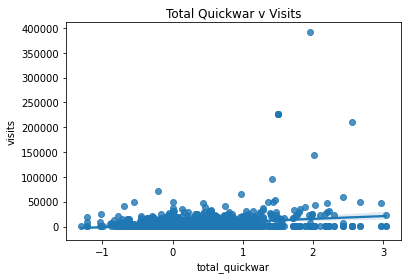

In [440]:
sns.regplot(data=page_merge, x="total_quickwar", y="visits").set(title='Total Quickwar v Visits')

In [401]:
test_merge = page_merge[1:]

In [403]:
test_merge.corr(method = 'pearson')

,visits,player_id,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
visits,1.000000,-0.155348,0.180112,0.108971,0.211103,0.202113
player_id,-0.155348,1.000000,-0.075612,-0.165006,-0.184468,-0.284473
hitting_quickwar,0.180112,-0.075612,1.000000,-0.105458,0.601065,0.518865
pitching_quickwar,0.108971,-0.165006,-0.105458,1.000000,0.731357,0.561752
total_quickwar,0.211103,-0.184468,0.601065,0.731357,1.000000,0.807318
performance_rank,0.202113,-0.284473,0.518865,0.561752,0.807318,1.000000


[Text(0.5, 1.0, 'Total Quickwar v Visits')]

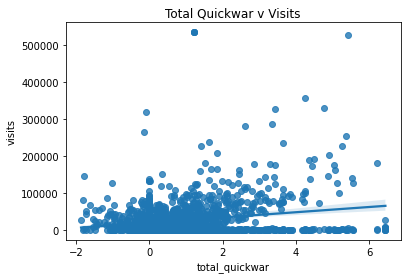

In [405]:
sns.regplot(data=test_merge, x="total_quickwar", y="visits").set(title='Total Quickwar v Visits')

In [244]:
#prediction for 2022

In [349]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [551]:
data3 = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk, game_Date FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2022-04-01' AND DATE '2022-09-01' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , EXTRACT(month FROM games.game_Date) as month
       , EXTRACT(year FROM games.game_Date) as year
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3, 4, 5
), hitters AS (
      SELECT player_id
           , player_name
           , month
           , year
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , month
          , year
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3, 4, 5
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , EXTRACT(month FROM games.game_Date) as month
         , EXTRACT(year FROM games.game_Date) as year
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2, 3, 4
), pitcher_war AS (
      SELECT player_id
           , player_name
           , month 
           , year
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.month, pitcher_war.month) AS month
           , COALESCE(hitters_war.year, pitcher_war.year) AS year
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war 
           ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
   AND hitters_war.month = pitcher_war.month
   AND hitters_war.year = pitcher_war.year
)
SELECT 
     player_id
     , player_name
     , month
     , year
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 2381/2381 [00:00<00:00, 8586.28rows/s]


In [552]:
data3

,player_id,player_name,month,year,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
0,595879,Ednel Baez,5.0,2022.0,H,-1.044158,0.0000,-1.044158,0.000000
1,642165,Josh VanMeter,7.0,2022.0,H,-0.331318,-0.6840,-1.015318,0.000420
2,624428,Adam Frazier,6.0,2022.0,H,-0.904306,0.0000,-0.904306,0.000840
3,641914,Sheldon Neuse,5.0,2022.0,H,-0.848889,0.0000,-0.848889,0.001261
4,592743,Andrelton Simmons,5.0,2022.0,H,-0.361140,-0.4420,-0.803140,0.001681
...,...,...,...,...,...,...,...,...,...
2376,605141,Markus Betts,5.0,2022.0,H,1.529261,0.0000,1.529261,0.998319
2377,656941,Kyle Schwarber,6.0,2022.0,H,1.530073,0.0000,1.530073,0.998739
2378,646240,Rafael Devers,5.0,2022.0,H,1.546801,0.0000,1.546801,0.999160
2379,502671,Paul Goldschmidt,5.0,2022.0,H,1.815523,0.0000,1.815523,0.999580


In [471]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit, EXTRACT(month FROM date_time_date) as month,
    EXTRACT(year FROM date_time_date) as year
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2022-04-01' AND date_time_date < '2022-8-01'
    )




        SELECT page_url, month, year, count(*) as visits
        FROM initial_query
        GROUP BY page_url, month, year
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 1023170/1023170 [00:43<00:00, 23262.12rows/s]


In [485]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [513]:
full_player_page = player_page_loads

In [518]:
def parse_player_ids(player_page):
    #player_page = df.query("source == 'player_page'")
    player_page['player_id'] = player_page['page_url'].str[-6:]
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    player_page['player_id'] = np.where(player_page.is_id == False, \
                                player_page['page_url'].str.split('?') \
                                        .str[0].str[-6:], player_page.player_id)
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    player_page['player_id'] = np.where(player_page.is_id == False, \
                               player_page['page_url'].str.split('#') \
                               .str[0].str[-6:], player_page.player_id)
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    
    player_page = player_page.query("is_id == True") # drop missing player_ids
        
    return player_page

In [524]:
full_player_page = parse_player_ids(player_page_loads)

In [526]:
#full_player_page['construct'] = names
full_player_page['name'] = full_player_page['construct'].apply(lambda x: "-".join(x.split("-")[:2]))
full_player_page['name'] = full_player_page['name'].apply(lambda x: x.replace('-',' '))
full_player_page['player_id'] = full_player_page['construct'].apply(lambda x: x.split('-')[-1:][0])
#full_player_page = full_player_page.head(4000)
full_player_page['player_id'] = full_player_page['player_id'].str.split('/', expand=True)[0]
full_player_page["is_numeric"] = full_player_page["player_id"].str.isnumeric()
full_player_page = full_player_page.query('is_numeric').reset_index(drop=True)
full_player_page['player_id'] = (pd.to_numeric(full_player_page["player_id"]))
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    This is separate from

In [517]:
full_player_page.query("player_id.str.contains('xgames')").values



array([['https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-660271/player-splits--last*20player-splits--last-3*20has-xgames',*5Cn__;JSUl!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqX3PuGfSw$          7, 2022, 1,
        'player-splits--last%20player-splits--last-3%20has-xgames',
        'player splits', 'xgames'],
       ['https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-660271/class=*22player-splits--last*20player-splits--last-3*20has-xgames*22',*5Cn__;JSUlJSU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUO7RVRjg$          6, 2022, 1,
        'class=%22player-splits--last%20player-splits--last-3%20has-xgames%22',
        'class=%22player splits', 'xgames%22'],
       ['https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-660271/player-splits--last*20player-splits--last-3*20has-xgames',*5Cn__;JSUl!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2

In [539]:
pages = full_player_page

In [489]:
data3

,player_id,player_name,month,year,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
0,672578,Carlos Hernandez,5.0,2022.0,P,0.000000,-1.1504,-1.150400,0.000000
1,621433,Brett Phillips,6.0,2022.0,H,-0.752906,-0.3420,-1.094906,0.000286
2,601713,Nicholas Pivetta,7.0,2022.0,P,0.000000,-1.0792,-1.079200,0.000573
3,608723,Austin Voth,5.0,2022.0,P,0.000000,-1.0592,-1.059200,0.000859
4,595879,Ednel Baez,5.0,2022.0,H,-1.044158,0.0000,-1.044158,0.001145
...,...,...,...,...,...,...,...,...,...
3489,607074,Carlos Rodon,6.0,2022.0,P,0.000000,1.5880,1.588000,0.998855
3490,645261,Sandy Alcantara,6.0,2022.0,P,0.000000,1.7376,1.737600,0.999141
3491,502671,Paul Goldschmidt,5.0,2022.0,H,1.815523,0.0000,1.815523,0.999427
3492,660271,Shohei Ohtani,6.0,2022.0,H,0.691567,1.1936,1.885167,0.999714


In [490]:
pages

,page_url,month,year,visits,construct,name,player_id
0,https://urldefense.com/v3/__https://www.mlb.com/player/michael-stefanic-68__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUZQqMHhg$ ...,7,2022,13563,michael-stefanic-683021,michael stefanic,683021
1,https://urldefense.com/v3/__https://www.mlb.com/player/andres-gimenez-665926__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUxeNqTXQ$,7,2022,22880,andres-gimenez-665926,andres gimenez,665926
2,https://urldefense.com/v3/__https://www.mlb.com/player/jurickson-profar-59__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVvuINyQg$ ...,7,2022,8145,jurickson-profar-595777,jurickson profar,595777
3,https://urldefense.com/v3/__https://www.mlb.com/player/drew-rasmussen-656876__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUt4joo9w$,7,2022,19573,drew-rasmussen-656876,drew rasmussen,656876
4,https://urldefense.com/v3/__https://www.mlb.com/player/keegan-thompson-624522__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqW-_FTuOw$,7,2022,22188,keegan-thompson-624522,keegan thompson,624522
...,...,...,...,...,...,...,...
3995,https://urldefense.com/v3/__https://www.mlb.com/player/anthony-santander-6__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUBZ_jOJA$ ...,7,2022,1,anthony-santander-623993,anthony santander,623993
3996,https://urldefense.com/v3/__https://www.mlb.com/player/jose-altuve-514888?__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWsASm0AA$ ...,7,2022,1,jose-altuve-514888,jose altuve,514888
3997,https://urldefense.com/v3/__https://www.mlb.com/player/pedro-diaz-665929__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWrt3fwLw$,7,2022,8,pedro-diaz-665929,pedro diaz,665929
3998,https://urldefense.com/v3/__https://www.mlb.com/player/nick-ahmed-605113?a__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXkB7vEfg$ ...,7,2022,1,nick-ahmed-605113,nick ahmed,605113


In [540]:
pages = pages.groupby(['player_id', 'month', 'year'])['visits'].sum().reset_index()

In [545]:
pages

,player_id,month,year,visits
0,110001,4,2022,1076
1,110001,5,2022,1097
2,110001,6,2022,678
3,110001,7,2022,802
4,110002,4,2022,19
...,...,...,...,...
172613,806430,7,2022,2
172614,806460,7,2022,1
172615,806464,7,2022,63
172616,806465,7,2022,5


In [553]:
data3.query("player_id == 660271").sort_values('month')

,player_id,player_name,month,year,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
2207,660271,Shohei Ohtani,4.0,2022.0,H,-0.008576,0.4380,0.429424,0.927311
2365,660271,Shohei Ohtani,5.0,2022.0,H,0.364956,0.6500,1.014956,0.993697
2380,660271,Shohei Ohtani,6.0,2022.0,H,0.691567,1.1936,1.885167,1.000000
2262,660271,Shohei Ohtani,7.0,2022.0,H,0.165062,0.4078,0.572862,0.950420


In [554]:
page_merge22 = pages.merge(data3, how = 'inner', on = ['player_id', 'month', 'year'])

In [555]:
pages.shape

(172618, 4)

In [556]:
page_merge22.shape

(1417, 10)

In [530]:
page_merge22.head(5).values

array([[405395, 4, 2022, '405395', 2, 'Jose Pujols', 'H',
        0.019296000000000032, -0.342, -0.322704, 0.08130546807901518],
       [405395, 4, 2022, 'albert pujols', 63103, 'Jose Pujols', 'H',
        0.019296000000000032, -0.342, -0.322704, 0.08130546807901518],
       [405395, 5, 2022, '405395', 1, 'Jose Pujols', 'H',
        -0.03840000000000003, -0.342, -0.38040000000000007,
        0.06212424849699399],
       [405395, 5, 2022, 'albert pujols', 62267, 'Jose Pujols', 'H',
        -0.03840000000000003, -0.342, -0.38040000000000007,
        0.06212424849699399],
       [405395, 6, 2022, 'albert pujols', 35484, 'Jose Pujols', 'H',
        -0.3520609523809525, -0.342, -0.6940609523809524,
        0.01259662181505869]], dtype=object)

In [557]:
page_merge22.sort_values('visits', ascending = False)

,player_id,month,year,visits,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
1150,660271,6,2022,270867,Shohei Ohtani,H,0.691567,1.1936,1.885167,1.000000
1149,660271,5,2022,254848,Shohei Ohtani,H,0.364956,0.6500,1.014956,0.993697
1151,660271,7,2022,249030,Shohei Ohtani,H,0.165062,0.4078,0.572862,0.950420
1148,660271,4,2022,186028,Shohei Ohtani,H,-0.008576,0.4380,0.429424,0.927311
444,592450,6,2022,181441,Aaron Judge,H,0.570797,0.0000,0.570797,0.949160
...,...,...,...,...,...,...,...,...,...,...
1050,650331,7,2022,1061,Lewin Diaz,H,-0.001540,0.0000,-0.001540,0.262605
1087,656514,7,2022,1037,Adam Haseley,H,0.025280,0.0000,0.025280,0.734874
759,621450,6,2022,893,Skye Bolt,H,-0.090240,0.0000,-0.090240,0.183193
730,621006,7,2022,821,Richard Martin,H,0.000000,0.0000,0.000000,0.265126


In [558]:
page_merge22.corr(method = 'pearson')

,player_id,month,year,visits,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,0.016287,NaN,-0.075010,0.044059,0.042697,0.050064,0.038089
month,0.016287,1.000000,NaN,-0.013873,0.085299,-0.014542,0.080909,0.061048
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,-0.075010,-0.013873,NaN,1.000000,0.298390,0.424474,0.361351,0.230150
hitting_quickwar,0.044059,0.085299,NaN,0.298390,1.000000,0.059250,0.986382,0.835003
pitching_quickwar,0.042697,-0.014542,NaN,0.424474,0.059250,1.000000,0.222628,0.121769
total_quickwar,0.050064,0.080909,NaN,0.361351,0.986382,0.222628,1.000000,0.835543
performance_rank,0.038089,0.061048,NaN,0.230150,0.835003,0.121769,0.835543,1.000000


In [563]:
sns.set_style('darkgrid')

[Text(0.5, 1.0, 'Total Quickwar v Visits')]

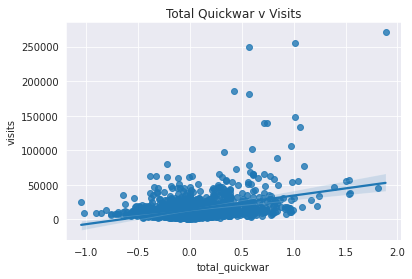

In [564]:
sns.regplot(data=page_merge22, x="total_quickwar", y="visits").set(title='Total Quickwar v Visits')

In [417]:
page_merge22 = page_merge22[1:]

In [425]:
concatenated = pd.concat([test_merge.assign(dataset='2021'), page_merge22.assign(dataset='2022')])

In [428]:
concatenated.head(40)

,page_url,visits,construct,name,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dataset
1,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,27567,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.000000,2021
2,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,7833,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.000000,2021
3,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,7615,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.000000,2021
4,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,5992,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.000000,2021
5,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,5324,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.000000,2021
6,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,4320,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.000000,2021
7,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,3710,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.000000,2021
8,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,2927,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.000000,2021
9,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-660271*__;Iw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVy_6e0jQ$,1411,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.000000,2021
10,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,1243,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.000000,2021


In [459]:
concatenated.sort_values('total_quickwar', ascending = False)

,page_url,visits,construct,name,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dataset
1,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,27567,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.00000,2021
8,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,2927,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.00000,2021
2,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,7833,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.00000,2021
12,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,805,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.00000,2021
11,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,1170,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,3.570849,2.8646,6.435449,1.00000,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
324,https://urldefense.com/v3/__https://www.mlb.com/player/matt-harvey-518774__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqV-JWJBTA$,81500,matt-harvey-518774,matt harvey,518774,Matthew Harvey,P,0.000000,-1.8066,-1.806600,0.00073,2021
962,https://urldefense.com/v3/__https://www.mlb.com/player/andrelton-simmons-5__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWwyRcflA$ ...,28817,andrelton-simmons-592743,andrelton simmons,592743,Andrelton Simmons,H,-1.866875,0.0000,-1.866875,0.00000,2021
449,https://urldefense.com/v3/__https://www.mlb.com/player/dallas-keuchel-5729__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWX0luD_w$ ...,597,dallas-keuchel-572971,dallas keuchel,572971,Dallas Keuchel,P,0.000000,-1.9784,-1.978400,0.00000,2022
448,https://urldefense.com/v3/__https://www.mlb.com/player/dallas-keuchel-5729__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWX0luD_w$ ...,688,dallas-keuchel-572971,dallas keuchel,572971,Dallas Keuchel,P,0.000000,-1.9784,-1.978400,0.00000,2022


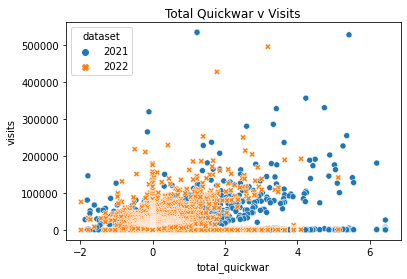

In [427]:
sns.scatterplot(x='total_quickwar', y='visits', data=concatenated,
                hue='dataset', style='dataset').set(title='Total Quickwar v Visits')
plt.show()

In [ ]:
#ignore

In [333]:
save_table = page_merge

In [334]:
y = page_merge['visits']

In [335]:
page_merge

,page_url,visits,construct,name,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
0,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-660271__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqU13e5xGw$,475756,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,0.736316,1.6014,2.337716,0.998537
1,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,7194,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,0.736316,1.6014,2.337716,0.998537
2,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,3413,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,0.736316,1.6014,2.337716,0.998537
3,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,3282,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,0.736316,1.6014,2.337716,0.998537
4,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,2897,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,0.736316,1.6014,2.337716,0.998537
...,...,...,...,...,...,...,...,...,...,...,...
2147,https://urldefense.com/v3/__https://www.mlb.com/player/helcris-olivarez-67__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXMLtlrAA$ ...,261,helcris-olivarez-672487,helcris olivarez,672487,Helcris Olivarez,None,0.000000,0.0000,0.000000,0.217264
2148,https://urldefense.com/v3/__https://www.mlb.com/player/yerry-rodriguez-666720__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWfNF1-OQ$,260,yerry-rodriguez-666720,yerry rodriguez,666720,Yerry Rodriguez,None,0.000000,0.0000,0.000000,0.217264
2149,https://urldefense.com/v3/__https://www.mlb.com/player/wandisson-charles-6__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVPMzp5bg$ ...,255,wandisson-charles-664301,wandisson charles,664301,Wandisson Charles,None,0.000000,0.0000,0.000000,0.217264
2150,https://urldefense.com/v3/__https://www.mlb.com/player/yasel-antuna-671276__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqU7myntJA$,254,yasel-antuna-671276,yasel antuna,671276,Yasel Antuna,None,0.000000,0.0000,0.000000,0.217264


In [336]:
page_merge = page_merge.drop(columns = ['hitting_quickwar', 'pitching_quickwar', 'performance_rank',
                                        'construct','position','page_url', 'visits', 'name',
                                        'player_id','player_name'])

In [344]:
page_merge

,total_quickwar
0,2.337716
1,2.337716
2,2.337716
3,2.337716
4,2.337716
...,...
2147,0.000000
2148,0.000000
2149,0.000000
2150,0.000000


In [345]:
y

0       475756
1         7194
2         3413
3         3282
4         2897
         ...  
2147       261
2148       260
2149       255
2150       254
2151       224
Name: visits, Length: 2152, dtype: int64

In [337]:
X_train, X_test, y_train, y_test = train_test_split(page_merge, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1721, 1) (1721,)
(431, 1) (431,)


In [338]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

Text(0.5, 1.0, 'True Values v Predictions')

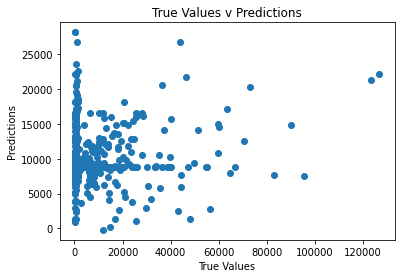

In [347]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title('True Values v Predictions')

In [340]:
print("Score:", model.score(X_test, y_test))

Score: -0.011707544317502094


In [341]:
predictions

array([ 8855.7988863 ,  8855.7988863 ,  5089.68634129,  8855.7988863 ,
        8855.7988863 , 11428.15387614,  2651.95757849,  8855.7988863 ,
        5840.93677924,  8855.7988863 ,  8855.7988863 ,  9565.45199513,
        1396.58554869,  8855.7988863 , 10877.48506844,  1062.81753769,
       14544.57624942,  7284.77572493,  8855.7988863 ,  7086.61718242,
       10587.46517909,  8855.7988863 ,  8855.7988863 ,  8855.7988863 ,
        8855.7988863 , 26689.54654685,  8855.7988863 ,  8855.7988863 ,
        8447.83086652,  8855.7988863 , 18081.28930111,  8855.7988863 ,
        8855.7988863 ,  8855.7988863 , 22220.25287758,  9086.84873569,
        8855.7988863 , 12085.09376586,  3866.77249561,  8855.7988863 ,
       10369.17539978, 10879.1354245 ,  8112.79720315,  7949.39620513,
        8855.7988863 ,  8855.7988863 , 11083.77957682, 10996.31070526,
        -221.46510397,  8855.7988863 ,  8855.7988863 , 20578.27803056,
       10289.95830857, 13554.36260919, 14665.05224232,  2879.85956751,
      

In [351]:
mean_squared_error(y_test, predictions)

298403595.3332272

In [ ]:
#try k fold cross validation?

In [352]:
#2021 season

In [354]:
data4 = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2021-04-01' AND DATE '2021-09-30' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3
), hitters AS (
      SELECT player_id
           , player_name
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2
), pitcher_war AS (
      SELECT player_id
           , player_name
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
)
SELECT 
     player_id
     , player_name
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 1371/1371 [00:00<00:00, 5769.90rows/s]


In [355]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2021-04-01' AND date_time_date < '2021-10-01'
    )




        SELECT page_url, count(*) as visits
        FROM initial_query
        GROUP BY page_url
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 196707/196707 [00:05<00:00, 34663.46rows/s]


In [356]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [357]:
full_player_page = player_page_loads

In [358]:
full_player_page['construct'] = names
full_player_page['name'] = full_player_page['construct'].apply(lambda x: "-".join(x.split("-")[:2]))
full_player_page['name'] = full_player_page['name'].apply(lambda x: x.replace('-',' '))
full_player_page['player_id'] = full_player_page['construct'].apply(lambda x: x.split('-')[-1:][0])
full_player_page = full_player_page.head(4000)
full_player_page['player_id'] = pd.to_numeric(full_player_page["player_id"])
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    import sys


In [359]:
pages = full_player_page

In [360]:
page_merge = pages.merge(data4, how = 'inner')

In [566]:
page_merge.corr(method = 'pearson')

,visits,player_id,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
visits,1.000000,-0.077366,0.117164,0.159440,0.204564,0.149274
player_id,-0.077366,1.000000,-0.017139,-0.160422,-0.147145,-0.215333
hitting_quickwar,0.117164,-0.017139,1.000000,-0.070562,0.522108,0.520580
pitching_quickwar,0.159440,-0.160422,-0.070562,1.000000,0.813912,0.591340
total_quickwar,0.204564,-0.147145,0.522108,0.813912,1.000000,0.808809
performance_rank,0.149274,-0.215333,0.520580,0.591340,0.808809,1.000000


[Text(0.5, 1.0, 'Total Quickwar v Visits')]

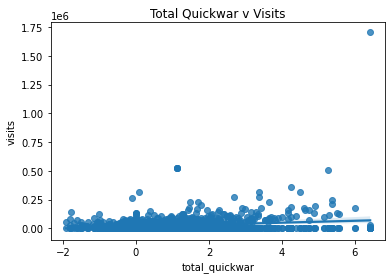

In [362]:
sns.regplot(data=page_merge, x="total_quickwar", y="visits").set(title='Total Quickwar v Visits')

In [377]:
page_merge.head(40)

,page_url,visits,construct,name,player_id,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
0,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-660271__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqU13e5xGw$,221482,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.062807,1.8436,2.906407,0.999269
1,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,3209,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.062807,1.8436,2.906407,0.999269
2,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,1681,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.062807,1.8436,2.906407,0.999269
3,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,1233,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.062807,1.8436,2.906407,0.999269
4,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,1217,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.062807,1.8436,2.906407,0.999269
5,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,814,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.062807,1.8436,2.906407,0.999269
6,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,691,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.062807,1.8436,2.906407,0.999269
7,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-66027__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVSs8dcMA$ ...,382,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.062807,1.8436,2.906407,0.999269
8,https://urldefense.com/v3/__https://www.mlb.com/player/shohei-ohtani-660271*__;Iw!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVy_6e0jQ$,252,shohei-ohtani-660271,shohei ohtani,660271,Shohei Ohtani,H,1.062807,1.8436,2.906407,0.999269
9,https://urldefense.com/v3/__https://www.mlb.com/player/aaron-judge-592450__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVlXeGh_Q$,130354,aaron-judge-592450,aaron judge,592450,Aaron Judge,H,1.647044,0.0000,1.647044,0.982456
